# Нейрон сүлжээг бичих, оролт гаралтын утгыг тооцоолох, сургалт хийх

ANN сургалтыг зөвхөн numpy cupy сан ашиглан туршилтын загвар үүсгэн сургалт хийх бөгөөд тайланг энэхүү notebook дээр хийн үр дүнг гарган илгээнэ. 
Энэхүү лабораторийн ажилыг гүйцэтгэснээр 
1. Машин сургалтын үндсэн зарчимуудыг хэрэглэх (apply) A.1
2. Неирон сүлжээний зарчимуудыг хэрэглэх (apply) A.2
3. Неирон сүлжээний загваруудыг шинжлэх (analyze) A.2
7. Хэрэглэгчид болон төсөлд оролцогчидын бодит шаардлага дээр үндэслэж, хиймэл оюуны загвар боловсруулах, сургах, шаардлагуудыг зохиомжлох (design) B.1

чадваруудыг эзэмших болно. 
<span style="color:red">Даалгавруудыг зөвхөн өөрийн бодож боловсруулсан кодоор бичиж гүйцэтгэнэ. Хугацаа 3 долоо хоног.</span>
## Шаардлагатай санг оруулах


In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Сургалтын өгөгдлийг оруулах болон боловсруулах
MNIST мэдээллийн сан нь гараар бичсэн цифрүүдийн мэдээллийн багц юм. Сургалтын 60 000 дээж, 10 000 сорьцтой. Зураг бүрийг 28x28 пикселээр дүрсэлсэн бөгөөд тус бүр нь саарал өнгийн утгаараа 0-255 утгыг агуулна. Энэ өгөгдлийг сүлжээндээ оруулахын өмнө үүнийг onehot кодчилох, normalize болгох шаардлагатай.

Сургалтын өгөгдлийн сонгодог жишээ болох MNIST санг татаж авах ба түүний өгөгдлийн 0с 1ийн хооронд болгон хөрвүүлэх нь нейрон сүлжээг сургахад илүү дөхөм байдаг. Мөн өгөгдлийн гаралтыг сургалтын моделийн ангилалын тоотой ижил тооны 0 болон 1 ийн дараалал байдалаар onehot кодлох шаардлагатай. Ингэснээр тухайн моделыг шууд сургах боломж бүрдэх юм. Pytorch Tensorflow гэх мэт API ууд нь эдгээр хөрвүүлэлтүүдийг шийдсэн байдаг.

In [10]:
def MNIST_load(path):
    def one_hot(y):
        table = np.zeros((y.shape[0], 10))
        for i in range(y.shape[0]):
            table[i][int(y[i][0])] = 1 
        return table

    def normalize(x): 
        x = x / 255
        return x 

    data = np.loadtxt('{}'.format(path), delimiter = ',', skiprows=1)

    return normalize(data[:,1:]),one_hot(data[:,:1])

X_train, y_train = MNIST_load('archive/mnist_train.csv')
X_test, y_test = MNIST_load('archive/mnist_test.csv')

## Уншиж авсан өгөгдлийг шалгая

In [11]:
print(X_train.shape, y_train.shape)
print(X_train[1], y_train[1])
print(X_test.shape, y_test.shape)

(60000, 784) (60000, 10)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.      

## Нейрон сүлжээний танилцуулга
Мэдрэлийн сүлжээ нь давхаргын бүтцэд байрлуулсан, хүний тархи тооцоолол хийдэгтэй адил загварчлагдсан нейронуудын (тооцоолох нэгж) цуглуулга юм. Энэ тохиргоо нь зургийн ангилал зэрэг хэв маягийг таних даалгавруудыг гүйцэтгэх боломжийг олгодог.

<p align="center" width="100%">
    <img width="33%" src="https://miro.medium.com/max/720/1*FAl8LoOdQVg6WmvkDuP8Dg.webp">
</p>


Мэдрэлийн сүлжээ нь хүн мэдрэхүйн эрхтнүүдээс мэдээлэл авч, өгөгдсөн жишээн дээр хамгийн ойр шийдвэр гаргаж сурдагтай адил. Мэдрэлийн сүлжээний диаграммыг зүүнээс баруун тийш уншдаг. Өгөгдөл нь нэг мэдрэлийн эсээс дараагийн давхаргад шилжих дарааллаар эцсийн мэдрэлийн эс хүртэл боловсруулагдаж үр дүнг гаргадаг.

Эцсийн таамаглалд загвар хэрхэн нөлөөлж байгааг харахын тулд [Tensorflow Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=spiral&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=8,8,6,6,4,2&seed=0.69013&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false).

## Perceptron

Перцептрон бол 1958 онд нэвтрүүлсэн биологийн нейроны математик загвар юм. Давхаргад байрлуулсан перцептронуудын хослолыг мэдрэлийн сүлжээ гэж нэрлэдэг. Нэгээс олон далд давхарга байгаа тохиолдолд “Гүн” гэж нэрлэнэ.

<p align="center" width="100%">
    <img width="33%" src="https://miro.medium.com/max/720/1*M430Y2QpsXlFL88xGY61_w.webp">
</p>

Оролт $X = [x_1, x_2, …, x_m]$ ууд жин $W = [w_1, w_2, …, w_m]$ үүдтэй матриц үржүүлэгдэн бүгдийг нэмсэн үр дүнд биас $b$ нэмж гаралтын утгыг идэвхжүүлэгч функц ашиглан гарган авна.

<p align="center" width="100%">
    <img width="33%" src="https://miro.medium.com/max/4800/1*_Jr6WYMq09Pia_VppNOv7Q.webp">
</p>

Идэвхжүүлэгч функцийн гол зорилго нь: 
Шугаман бус идэвхжүүлэлтийн функц нь нейронуудын хоорондох шугаман байдлыг эвдэж, илүү төвөгтэй хэв маягийг олох боломжийг олгодог. Үүнгүйгээр энэ нь зүгээр л шугаман ангилагч эсвэл регресс юм.
<p align="center" width="100%">
    <img width="33%" src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*ZafDv3VUm60Eh10OeJu1vw.png">
</p>



Sigmoid эсвэл Tanh гэх мэт олон идэвхжүүлэх функцууд байдаг. Бид хамгийн алдартай нь болох ReLU-г сонгох болно, энэ нь энгийн учраас тооцоолоход илүү хурдан байдаг. Бид мөн сүүлийн давхаргад Softmax функцийг нэмдэг бөгөөд энэ нь гаралтыг магадлалын тархалт болгон хувиргадаг.

1. Жин нь мэдрэлийн эсүүдийн хоорондын холболтын хүчийг тодорхойлдог.

2. Bias нь идэвхжүүлэх функцийг өөрчилдөг тул нейроныг асаахад бага эсвэл өндөр утгатай байх шаардлагатай.

## Сургалтын процесс

Шууд болон гэдрэг гэсэн хоёр төрлийн процессийг сургалтанд ашигладаг.

<p align="center" width="100%">
    <img width="33%" src="https://miro.medium.com/max/640/1*nTHoUrFO1WIcovnwC3wS_Q.gif">
</p>

Feedforward - бид мэдрэлийн сүлжээг өгөгдөлөөр тэжээдэг бөгөөд энэ нь бүх давхаргуудаар дамждаг. Нэг давхарга дахь идэвхжүүлэлтийн загвар бүр нь дараагийн давхарга дахь идэвхжүүлэлтийн загварын оролт гэх мэтээр эцсийн дүндээ гаралтын давхаргад таамаглал гарган авахад хүргэдэг. Давхрага бүр дээрхи математик тооцоолол нь перцептронтой адил матрицын үржүүлэг юм.

$$
a_l = ReLU(z_l)
$$
$$
z_l = (w_l \cdot a_{l-1}) + b_l
$$

Backpropagation - Буцах тархалт нь урьдчилан таамагласан болон хүссэн үр дүнгийн ялгаан дээр үндэслэн жин ба хэвийх утгыг шинэчилдэг сургалтын үйл явц юм. Сүлжээний алдааг хэмжихийн тулд бид Зардлын функцийг ашигладаг.

$$
Cost = \frac{1}{2m} \Sigma_{i=1}^m({y}-\hat{y})^2
$$
$y$ таамаглал, $\hat{y}$ гаралт target, $m$ гаралтын хэмжээ

Сургалтын үйл явцын эцсийн зорилго нь цаг хугацааны явцад алдааг аажмаар багасгах юм. Энэ нь функц учраас бид global хамгийн бага хэмжээг хайна. Хамгийн бага руу чиглэсэн алхмуудын чиглэлийг олохын тулд градиент уруу аргыг ашигладаг.

<p align="center" width="100%">
    <img width="33%" src="https://miro.medium.com/max/640/1*hxnqRIxiyCgDToM5hXb09Q.gif">
</p>

Олон хувьсагч функцийн градиент (өгсөх) нь функцийг хамгийн хурдан нэмэгдүүлэхийн тулд алхам хийх шаардлагатай чиглэлийг заадаг вектор юм. Бид градиентийн сөрөг утгыг авах замаар функцийг багасгах хамгийн хурдан арга замыг олж авдаг. "Алхам" -ын хэмжээг сурах хурдаар тодорхойлно. Хэт том утга нь доод хэмжээг давдаг бол хэт бага утга нь хэзээ ч хүрэхгүй.

$$
Gradient_{w_l} = \frac{\partial Cost}{\partial w_l}
$$

$$
Gradient_{b_l} = \frac{\partial Cost}{\partial b_l}
$$

$$
{w_l} = {w_l} - \alpha*\frac{\partial Cost}{\partial w_l}
$$

$$
{b_l} = {b_l} - \alpha*\frac{\partial Cost}{\partial b_l}
$$

Харамсалтай нь Зардлын функц нь жингээс шууд хамаардаггүй. Ийм хамаарлыг олохын тулд бид нийлмэл функцийг задалдаг Гинжин дүрмийн аргыг ашиглах хэрэгтэй.

$$
Gradient_{w_l} = \frac{\partial Cost}{\partial w_l} = \frac{\partial Cost}{\partial a_l} * \frac{\partial a_l}{\partial z_l} * \frac{\partial z_l}{\partial w_l}
$$

$$
\frac{\partial Cost}{\partial a_l} = (\frac{1}{2m} ({y}-\hat{y})^2)^{'} = \frac{1}{m}({y}-\hat{y})
$$

$$
\frac{\partial a_l}{\partial z_l}  = (\psi(z_l))^{'}=\psi^{'}(z_l)
$$

$$
\frac{\partial z_l}{\partial w_l} = (w_l * a_{l-1} + b_l)^{'} = a_{l-1}
$$

$$
Gradient_{w_l} = \frac{1}{m}({y}-\hat{y}) * \psi^{'}(z_l) * a_{l-1}
$$

$$
Gradient_{b_l} = \frac{1}{m}\sum({y}-\hat{y}) * \psi^{'}(z_{li})
$$

## Стохастик градиент уналт

Өгөгдлийн багц дахь жишээ бүрийн градиентийг тооцоолох нь маш үр ашиггүй юм (Online learning). Тиймээс бид өгөгдлийг бага багц болгон хувааж, түүн дээр градиент тооцоолно. Энэ нь нэг градиент шиг нарийвчлалтай биш юм. Гэсэн хэдий ч энэ нь тооцоололд ихээхэн түлхэц өгч, том өгөгдлийн багцад илүү сайн ажилладаг. Мөн бид үүний "стохастик" хэсгийг нэмж, бүх сургалтын багцийг сургалтын загвараар оруулан гаргах бүрт өгөгдлийн багцыг хольдог.

## Нейрон сүлжээний загварчлал

1. Оролт 784
2. hidden1 256
3. hidden2 128
4. Гаралт 10

Жингүүд болон bias - ийн утгуудыг санамсаргүйгээр эхлүүлэх

In [12]:
class NeuralNetwork_weights:
    def __init__(self, X, y, batch = 64, lr = 1e-3,  epochs = 50):
        self.input = X 
        self.target = y
        self.batch = batch
        self.epochs = epochs
        self.lr = lr
        
        self.x = self.input[:self.batch] # эхний багц оролт
        self.y = self.target[:self.batch] # эхний багц target
        self.loss = []
        self.acc = []
        
        self.init_weights()
      
    def init_weights(self):
        # энд жин болон bias-ийг np.random.randn ашиглан үүсгэнэ.
        self.weights1 = None
        self.weights2 = None
        self.weights3 = None

        self.bias1 = None
        self.bias2 = None
        self.bias3 = None

In [14]:
NN = NeuralNetwork_weights(X_train[:100, :], y_train[:100, :])
print(NN.weights1)
# print(NN.weights2.shape)
# print(NN.weights3.shape)
# print(NN.bias1.shape)
# print(NN.bias2.shape)
# print(NN.bias3.shape)

None


### Хүлээгдэж буй гаралт:
(784, 256)

(256, 128)

(128, 10)

(256,)

(128,)

(10,)

In [15]:
class NeuralNetwork_activation(NeuralNetwork_weights):
    def __init__(self, X, y, batch=64, lr=0.001, epochs=50):
        super().__init__(X, y, batch, lr, epochs)
        
    def ReLU(self, x): #relu forward
        return np.maximum(0,x)

    def dReLU(self,x): # delta relu гэдрэг урсгалд
        return 1 * (x > 0) 
    
    def softmax(self, z):
        z = z - np.max(z, axis = 1).reshape(z.shape[0],1)
        return np.exp(z) / np.sum(np.exp(z), axis = 1).reshape(z.shape[0],1)

## forwar болон back функцуудыг бичих

In [16]:
class NeuralNetwork_forward_back(NeuralNetwork_activation):
    def __init__(self, X, y, batch=64, lr=0.001, epochs=50):
        super().__init__(X, y, batch, lr, epochs)
        
    def shuffle_dataset(self):
        idx = [i for i in range(self.input.shape[0])]
        np.random.shuffle(idx)
        self.input = self.input[idx]
        self.target = self.target[idx]
        
    def forward(self):
        assert self.x.shape[1] == self.weights1.shape[0]
        self.z1 = None
        self.a1 = None # ReLU

        assert self.a1.shape[1] == self.weights2.shape[0]
        self.z2 = None
        self.a2 = None # ReLU

        assert self.a2.shape[1] == self.weights3.shape[0]
        self.z3 = None
        self.a3 = None # Softmax
        self.error = self.a3 - self.y

        
    def back(self):
        dcost = None
        
        Dweights3 = None # градиентуудыг chain rule ашиглан тооцоолно уу
        Dweights2 = None
        Dweights1 = None

        dbias3 = None
        dbias2 = None
        dbias1 = None
        
        assert Dweights3.shape == self.weights3.shape
        assert Dweights2.shape == self.weights2.shape
        assert Dweights1.shape == self.weights1.shape
        
        assert dbias3.shape == self.bias3.shape
        assert dbias2.shape == self.bias2.shape
        assert dbias1.shape == self.bias1.shape  # assert алдаа заагаагүй болон chain rule тооцоолол зөв тохиолдолд сургалтын функцээр шалгана 
        
        self.weights3 = self.weights3 - self.lr * Dweights3
        self.weights2 = self.weights2 - self.lr * Dweights2
        self.weights1 = self.weights1 - self.lr * Dweights1
        
        self.bias3 = self.bias3 - self.lr * dbias3
        self.bias2 = self.bias2 - self.lr * dbias2
        self.bias1 = self.bias1 - self.lr * dbias1


In [17]:
class NeuralNetwork_train_test(NeuralNetwork_forward_back):
    def __init__(self, X, y, batch=64, lr=0.001, epochs=50):
        super().__init__(X, y, batch, lr, epochs)    

    def train(self):
        for epoch in range(self.epochs):
            l = 0
            acc = 0
            self.shuffle()
            
            for batch in range(self.input.shape[0]//self.batch-1):
                start = batch*self.batch
                end = (batch+1)*self.batch
                self.x = self.input[start:end]
                self.y = self.target[start:end]
                self.forward()
                self.back()
                l+=np.mean(self.error**2)
                acc+= np.count_nonzero(np.argmax(self.a3,axis=1) == np.argmax(self.y,axis=1)) / self.batch
                
            self.loss.append(l/(self.input.shape[0]//self.batch))
            self.acc.append(acc*100/(self.input.shape[0]//self.batch))
            
    def test(self,xtest,ytest):
        self.x = xtest
        self.y = ytest
        self.forward()
        acc = np.count_nonzero(np.argmax(self.a3,axis=1) == np.argmax(self.y,axis=1)) / self.x.shape[0]
        print("Accuracy:", 100 * acc, "%")
            
    def plot(self):
        plt.figure(dpi = 125)
        plt.plot(self.loss)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
    
    def acc_plot(self):
        plt.figure(dpi = 125)
        plt.plot(self.acc)
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        


## Compile эмхтгэл шалгалт

In [19]:
NN = NeuralNetwork_train_test(X_train[:1000, :], y_train[:1000, :]) 
# NN.train()
# NN.plot()
# NN.test(X_test[:1000],y_test[:1000])


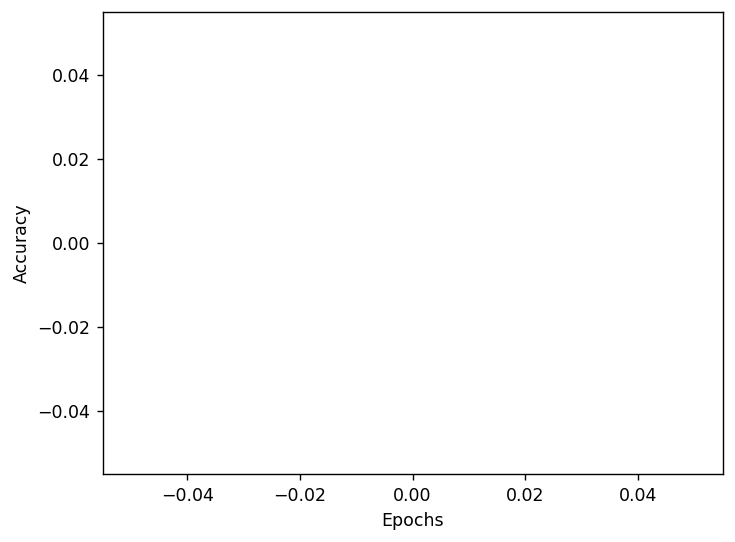

In [20]:
NN.acc_plot()

## Бүгдийг нэгтгэн class бичвэл

In [21]:
class NeuralNetwork:
    def __init__(self, X, y, batch = 64, lr = 1e-3,  epochs = 50):
        self.input = X 
        self.target = y
        self.batch = batch
        self.epochs = epochs
        self.lr = lr
        
        self.x = self.input[:self.batch] # batch input 
        self.y = self.target[:self.batch] # batch target value
        self.loss = []
        self.acc = []
        
        self.init_weights()
      
    def init_weights(self):
        pass

    def ReLU(self, x):
        return np.maximum(0,x)

    def dReLU(self,x):
        return 1 * (x > 0) 
    
    def softmax(self, z):
        z = z - np.max(z, axis = 1).reshape(z.shape[0],1)
        return np.exp(z) / np.sum(np.exp(z), axis = 1).reshape(z.shape[0],1)
    
    def shuffle(self):
        idx = [i for i in range(self.input.shape[0])]
        np.random.shuffle(idx)
        self.input = self.input[idx]
        self.target = self.target[idx]
        
    def forward(self):
        pass

        
    def back(self):
        pass

    def train(self):
        for epoch in range(self.epochs):
            l = 0
            acc = 0
            self.shuffle()
            
            for batch in range(self.input.shape[0]//self.batch-1):
                start = batch*self.batch
                end = (batch+1)*self.batch
                self.x = self.input[start:end]
                self.y = self.target[start:end]
                self.forward()
                self.back()
                l+=np.mean(self.error**2)
                acc+= np.count_nonzero(np.argmax(self.a3,axis=1) == np.argmax(self.y,axis=1)) / self.batch
                
            self.loss.append(l/(self.input.shape[0]//self.batch))
            self.acc.append(acc*100/(self.input.shape[0]//self.batch))
            
    def plot(self):
        plt.figure(dpi = 125)
        plt.plot(self.loss)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
    
    def acc_plot(self):
        plt.figure(dpi = 125)
        plt.plot(self.acc)
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        
    def test(self,xtest,ytest):
        self.x = xtest
        self.y = ytest
        self.forward()
        acc = np.count_nonzero(np.argmax(self.a3,axis=1) == np.argmax(self.y,axis=1)) / self.x.shape[0]
        print("Accuracy:", 100 * acc, "%")
        return np.argmax(self.a3,axis=1)

In [22]:
NN = NeuralNetwork(X_train[:1000, :], y_train[:1000, :]) 
NN.train()
NN.plot()
NN.test(X_test[:1000],y_test[:1000])

AttributeError: 'NeuralNetwork' object has no attribute 'error'

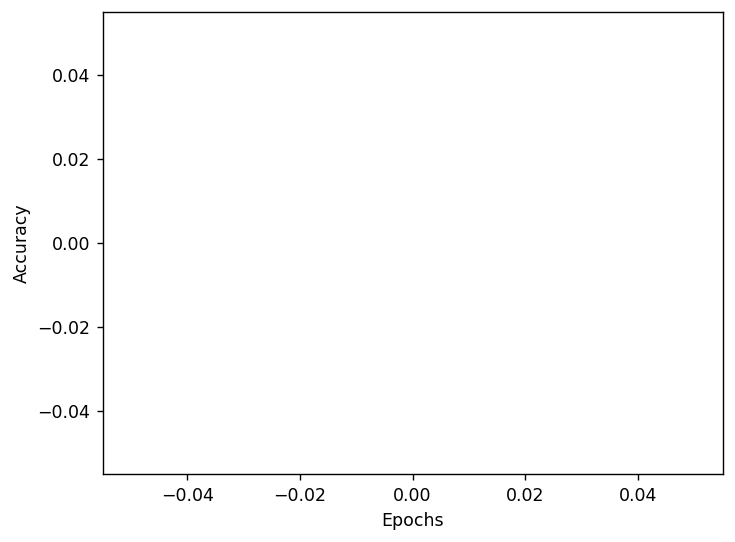

In [23]:
NN.acc_plot()

## Эцсийн сургалт

Сургалт нь ойролцоогоор 10 минут үргэлжлэх бөгөөд тестийн санд 91% танилт хийгдэнэ.

## Даалгавар 1
1. Дээх загварыг сурган алдааны болон амжилттай танилтын график байгуулна уу

In [24]:
NN = NeuralNetwork(X_train, y_train) 
NN.train()
NN.plot()
NN.test(X_test,y_test)
NN.acc_plot()

AttributeError: 'NeuralNetwork' object has no attribute 'error'

## Даалгавар 2
2. Сурсан загварын үнэлгээний шинжилгээг Sklearn metric ашиглан боломжит үнэлгээнүүдийг гаргана уу

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, classification_report
predictions = NN.test(X_test, y_test)
cm = confusion_matrix(y_test, predictions, labels=10)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=10)
disp.plot()
plt.show()
# бусад score


AttributeError: 'NeuralNetwork' object has no attribute 'a3'

## Даалгавар 3
3. Дээрх загварыг 3 далд давхрагатай болгон өөрчилж сургалтыг хийж нийт ашиглагдаж байгаа параметрийн тоог гаргана уу.

In [ ]:
class NeuralNetwork_3hidden(NeuralNetwork):
    def __init__(self, X, y, batch=64, lr=0.001, epochs=50):
        super().__init__(X, y, batch, lr, epochs)
    def init_weights(self):
        pass

        
    def forward(self):
        pass

        
    def back(self):
        pass

In [ ]:
NN = NeuralNetwork_3hidden(X_train, y_train) 
NN.train()
NN.plot()
NN.test(X_test,y_test)
NN.acc_plot()

## Даалгавар 4
4. Дээрх кодыг ашиглан [CUPY](https://cupy.dev/) санд хөрвүүлэн бичиж, colab gpu дээр сургалт хийгдсэн хугацааг гаргана уу

## Даалгавар 5
5. (Нэмэлт) Нейрон сүлжээний идэвхигүй параметрүүдийг алгасах буюу Dropout функцийг далд давхрагуудад хэрэгжүүлнэ үү.

# Тайлан
Дүгнэлт

Оюутны овог:

Нэр:

Код:


(Энд сурч мэдсэн зүйлсээ 300 үгэнд багтаан бичнэ үү)